## 🧩 Notebook 09: Interpolation & Curve Fitting with SciPy

In [1]:
# Setup and Imports
import numpy as np
from numpy import polyfit, poly1d
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from sklearn.metrics import root_mean_squared_error, r2_score
from scipy.optimize import curve_fit
from scipy.interpolate import griddata, Rbf

# ✅ Setup path to use utils
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from utils.interpolation_utils import (
    linear_interpolate,
    cubic_interpolate,
    spline_interpolate,
    multivariate_interpolate,
    fit_curve,
    exponential_model,
    gaussian_model,
    safe_gaussian_fit
)


from utils.viz_utils import (
    plot_interpolation_comparison,
    plot_curve_fits_with_bands,
    plot_multivariate_griddata,
    plot_rbf_interpolation,
    plot_gaussian_fit_with_band,
    plot_polynomial_fit,
    plot_all_fits_comparison,
    plot_residuals_comparison,
    plot_weighted_vs_unweighted_fit,
    plot_multivariate_error_heatmap,
    save_and_show_plot
)


# Constants
DATA_PATH = Path("../synthetic_data/exports")
EXPORT_PLOTS = Path("../exports/plots/09_interpolation_curvefitting")
EXPORT_TABLES = Path("../exports/tables/09_interpolation_curvefitting")

EXPORT_PLOTS.mkdir(parents=True, exist_ok=True)
EXPORT_TABLES.mkdir(parents=True, exist_ok=True)

## 🔹 Step 1: Load Synthetic Data (e.g., Noisy Sine Wave)

In [2]:
# Load synthetic interpolation dataset
df = pd.read_csv(DATA_PATH / "curve_fitting_data.csv")
df.head()

x = df["x"]
y = df["y"]

## 🔹 Step 2: Interpolation — Linear, Cubic, and Spline

In [3]:
# Define interpolation range
x_new = np.linspace(x.min(), x.max(), 200)

# Linear
lin_fn = linear_interpolate(x, y)
y_lin = lin_fn(x_new)

# Cubic
cub_fn = cubic_interpolate(x, y)
y_cub = cub_fn(x_new)

# Spline
spl_fn = spline_interpolate(x, y)
y_spl = spl_fn(x_new)

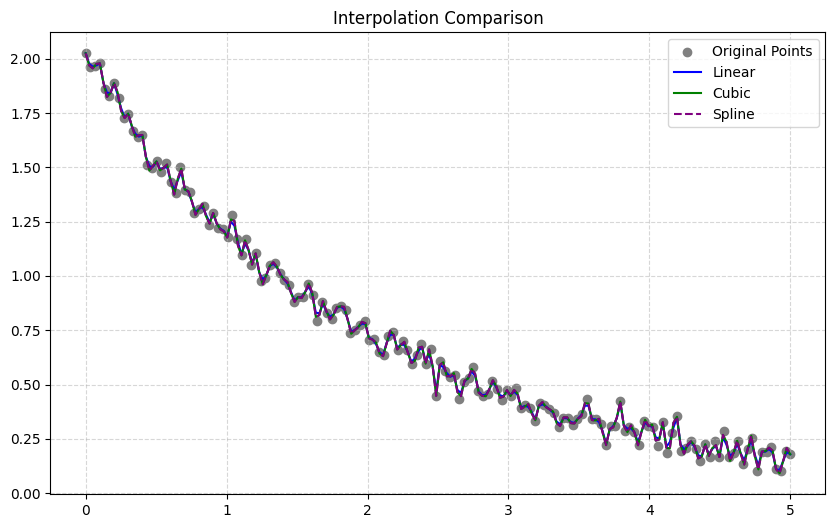

In [4]:
# Plot
fig_interp = plot_interpolation_comparison(x, y, x_new, y_lin, y_cub, y_spl)
save_and_show_plot(fig_interp, EXPORT_PLOTS / "interpolation_comparison.png")

In [5]:
# RMSE
rmse_lin = root_mean_squared_error(y, lin_fn(x))
rmse_cub = root_mean_squared_error(y, cub_fn(x))
rmse_spl = root_mean_squared_error(y, spl_fn(x))

rmse_df = pd.DataFrame({
    "Method": ["Linear", "Cubic", "Spline"],
    "RMSE": [rmse_lin, rmse_cub, rmse_spl]
})
rmse_df.to_csv(EXPORT_TABLES / "interpolation_rmse.csv", index=False)
display(rmse_df)


,Method,RMSE
0,Linear,0.000000e+00
1,Cubic,7.675977e-17
2,Spline,1.432172e-16


In [6]:
interp_df = pd.DataFrame({
    "x_new": x_new,
    "Linear": y_lin,
    "Cubic": y_cub,
    "Spline": y_spl
})
interp_df.to_csv(EXPORT_TABLES / "interpolation_curves.csv", index=False)

## 🔹 Step 3: Curve Fitting — Exponential & Gaussian

In [7]:
# Exponential Fit with custom initial guess and higher iterations
popt_exp, _ = fit_curve(exponential_model, x, y, p0=(1, -0.5, 0.1))
y_exp = exponential_model(x_new, *popt_exp)

# Fit exponential with covariance
popt_exp, pcov_exp = curve_fit(exponential_model, x, y, p0=(1, -0.5, 0.1), maxfev=5000)
y_exp_pred = exponential_model(x_new, *popt_exp)

# Confidence interval (±2σ for first parameter as example)
y_exp_err = 2 * np.sqrt(np.diag(pcov_exp))[0]
y_exp_upper = y_exp_pred + y_exp_err
y_exp_lower = y_exp_pred - y_exp_err


# Gaussian Fit
if np.all(np.diff(y) < 0) or np.all(np.diff(y) > 0):
    print("⚠️ Data is monotonic; Gaussian fit may not be appropriate.")

# Gaussian Fit with bounds and safe handling
popt_gauss, _ = safe_gaussian_fit(x, y, maxfev=10000)
y_gauss = gaussian_model(x_new, *popt_gauss)

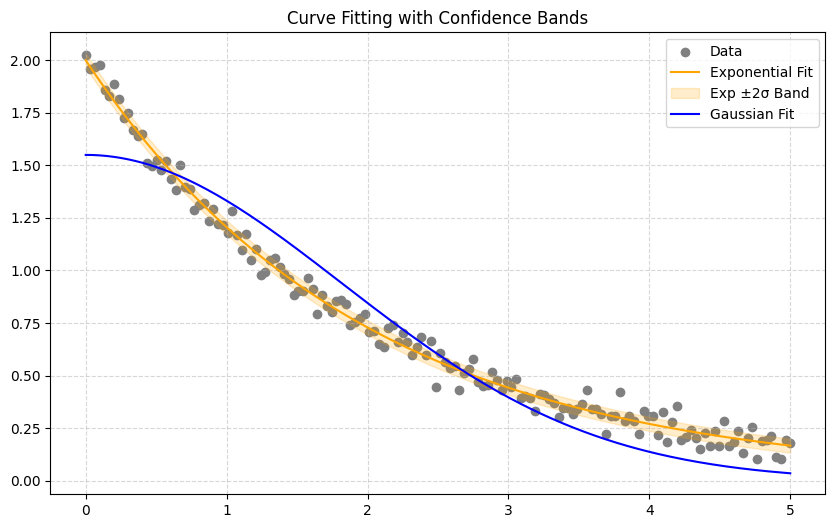

In [8]:
# Plot
fig_curve = plot_curve_fits_with_bands(x, y, x_new, y_exp_pred, y_exp_lower, y_exp_upper, y_gauss)
save_and_show_plot(fig_curve, EXPORT_PLOTS / "curve_fits_with_bands.png")

In [9]:
# fit_results
fit_results = pd.DataFrame({
    "Model": ["Exponential", "Gaussian"],
    "Parameters": [popt_exp.tolist(), popt_gauss.tolist()]
})
fit_results.to_csv(EXPORT_TABLES / "curve_fit_parameters.csv", index=False)
display(fit_results)

,Model,Parameters
0,Exponential,"[1.9885231743739498, -0.509518662603195, 0.010..."
1,Gaussian,"[6.52545640898107e-18, 1.8163544739990114, 1.5..."


#### Weighted Fit

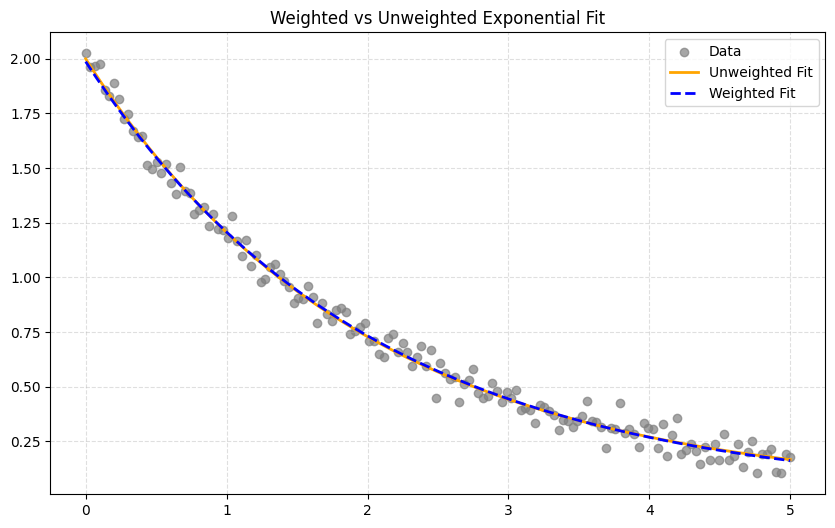

In [10]:
# Weighted Exponential Fit
# Weighted Exponential Fit with stable settings
weights = np.linspace(1, 3, len(x))
p0_weighted = (y.max(), -0.5, y.min())

popt_weighted, _ = curve_fit(
    exponential_model,
    x,
    y,
    sigma=1/weights,
    absolute_sigma=True,
    p0=p0_weighted,
    maxfev=10000
)

y_weighted = exponential_model(x_new, *popt_weighted)


# Weighted predictions
y_weighted_pred = exponential_model(x, *popt_weighted)
rmse_weighted = root_mean_squared_error(y, y_weighted_pred)
r2_weighted = r2_score(y, y_weighted_pred)


fig_weighted = plot_weighted_vs_unweighted_fit(x, y, x_new, y_exp_pred, y_weighted)
save_and_show_plot(fig_weighted, EXPORT_PLOTS / "weighted_vs_unweighted_fit.png")


In [11]:
# Polynomial Fit (moved up to avoid NameErrors)
poly_degree = 2
coeffs = np.polyfit(x, y, deg=poly_degree)
poly_fn = poly1d(coeffs)
y_poly = poly_fn(x_new)

## 🔹 Step 4: Multivariate Interpolation using `griddata`

In [12]:
# Create synthetic 2D data
np.random.seed(42)
x_2d = np.random.rand(100)
y_2d = np.random.rand(100)
z_2d = np.sin(x_2d * 4) * np.cos(y_2d * 4)

# Grid to interpolate on
grid_x, grid_y = np.meshgrid(
    np.linspace(0, 1, 100),
    np.linspace(0, 1, 100)
)

# Apply griddata interpolation
points = np.column_stack((x_2d, y_2d))
xi = (grid_x, grid_y)
grid_z = multivariate_interpolate(points, z_2d, xi, method='cubic')


# Export
pd.DataFrame(grid_z).to_csv(EXPORT_TABLES / "griddata_results.csv", index=False)

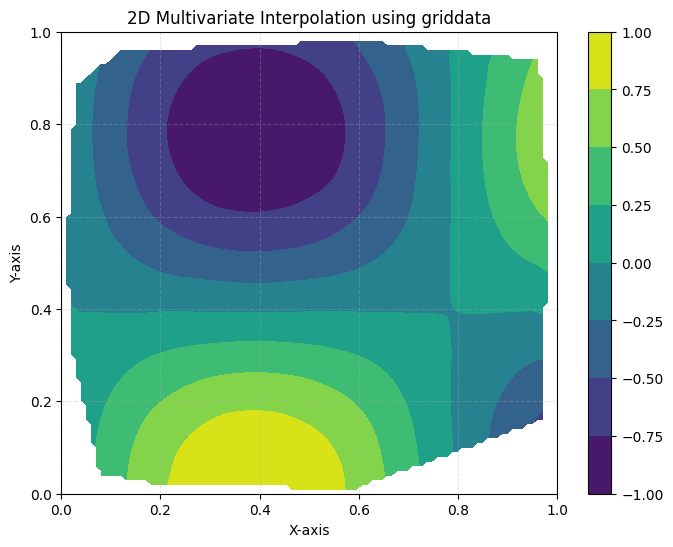

In [13]:
# Plot the interpolated surface
fig_grid = plot_multivariate_griddata(grid_x, grid_y, grid_z)
save_and_show_plot(fig_grid, EXPORT_PLOTS / "griddata_2d_interpolation.png")

## 🔹 Step 5: RBF Interpolation (Radial Basis Function)

In [14]:
# RBF model
rbf_model = Rbf(x_2d, y_2d, z_2d, function='multiquadric', smooth=0.1)
z_rbf = rbf_model(grid_x, grid_y)

pd.DataFrame(z_rbf).to_csv(EXPORT_TABLES / "rbf_results.csv", index=False)

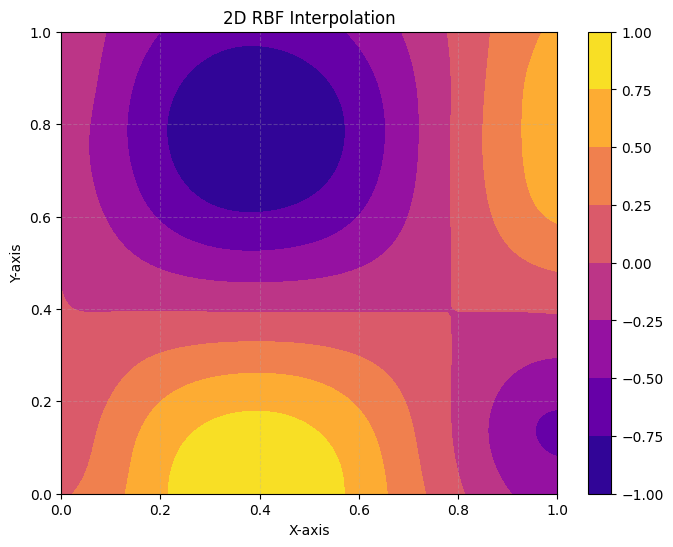

In [15]:
# Plot RBF interpolated surface
fig_rbf = plot_rbf_interpolation(grid_x, grid_y, z_rbf)
save_and_show_plot(fig_rbf, EXPORT_PLOTS / "2d_rbf_interpolation.png")

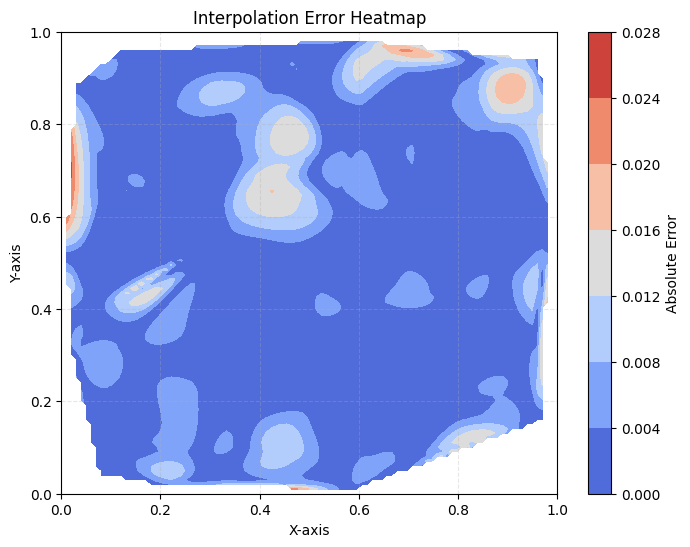

In [16]:
# Compute true surface for error calculation
true_surface = np.sin(grid_x * 4) * np.cos(grid_y * 4)
error_grid = np.abs(true_surface - grid_z)

fig_error = plot_multivariate_error_heatmap(grid_x, grid_y, error_grid)
save_and_show_plot(fig_error, EXPORT_PLOTS / "griddata_error_heatmap.png")

## 🔹 Step 6: Add Error Bands to Curve Fit (Gaussian)

In [17]:
# Gaussian Fit with robust initial guess and more iterations
popt_gauss, pcov = safe_gaussian_fit(x, y, maxfev=10000)

y_pred = gaussian_model(x_new, *popt_gauss)

# Confidence Interval (±2 std dev)
y_err = 2 * np.sqrt(np.diag(pcov))
y_upper = y_pred + y_err[0]
y_lower = y_pred - y_err[0]

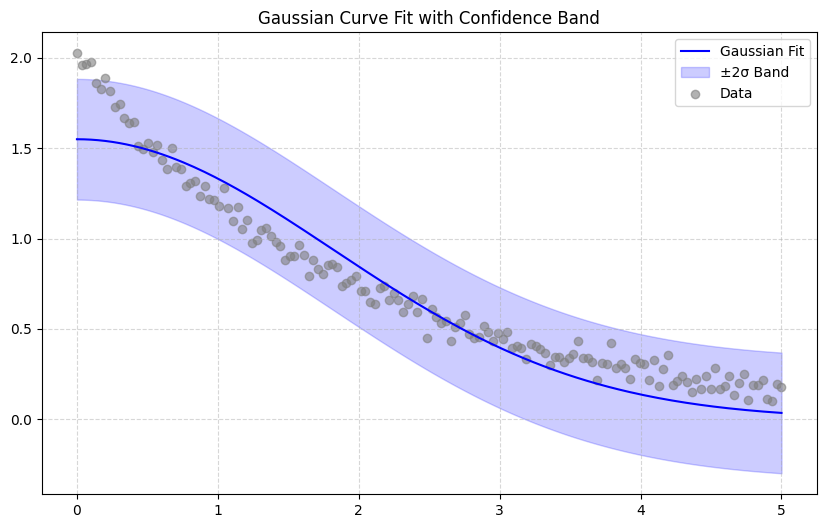

In [18]:
# Plot with confidence band
fig_gauss = plot_gaussian_fit_with_band(x, y, x_new, y_pred, y_lower, y_upper)
save_and_show_plot(fig_gauss, EXPORT_PLOTS / "gaussian_fit_with_band.png")

## 🔹 Step 7: Polynomial Fit

In [19]:
# Polynomial Fit Export
pd.DataFrame({"x_new": x_new, "Polynomial_Fit": y_poly}).to_csv(EXPORT_TABLES / "poly_fit_results.csv", index=False)

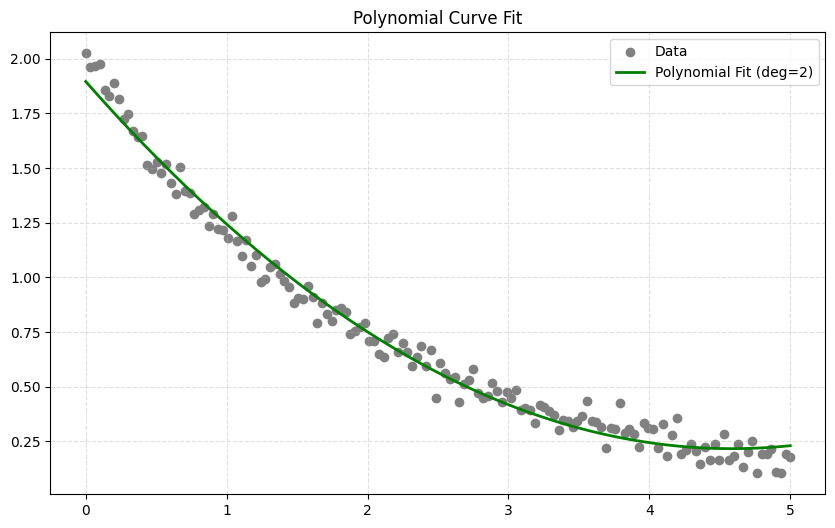

In [20]:
# plot
fig_poly = plot_polynomial_fit(x, y, x_new, y_poly, degree=poly_degree)
save_and_show_plot(fig_poly, EXPORT_PLOTS / "polynomial_fit.png")

## 🔹 Step 8: Residual Comparison

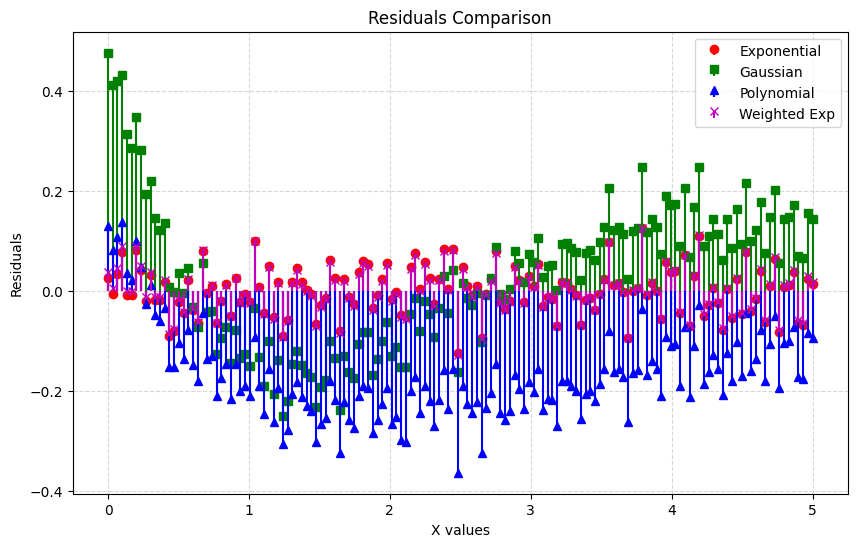

In [21]:
# Residuals
res_exp = y - exponential_model(x, *popt_exp)
res_gauss = y - gaussian_model(x, *popt_gauss)
res_poly = y - y_poly[:len(y)]
res_weighted = y - y_weighted_pred


fig_residuals = plot_residuals_comparison(x, res_exp, res_gauss, res_poly, res_weighted)
save_and_show_plot(fig_residuals, EXPORT_PLOTS / "residuals_comparison.png")

## 🔹 Step 9: All Fit Overlay

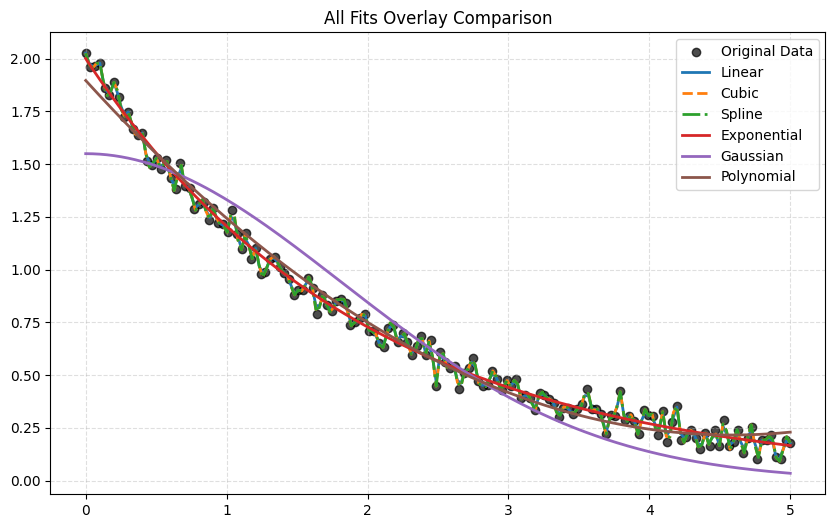

In [22]:
fig_all = plot_all_fits_comparison(x, y, x_new, y_lin, y_cub, y_spl,
                                   y_exp_pred, y_gauss, y_poly)
save_and_show_plot(fig_all, EXPORT_PLOTS / "all_fits_comparison.png")

## 🔹 Step 10: Final summary table of methods

In [23]:
# Exponential Fit Metrics
rmse_exp = root_mean_squared_error(y, exponential_model(x, *popt_exp))
r2_exp = r2_score(y, exponential_model(x, *popt_exp))

# Gaussian Fit Metrics
rmse_gauss = root_mean_squared_error(y, gaussian_model(x, *popt_gauss))
r2_gauss = r2_score(y, gaussian_model(x, *popt_gauss))

# Polynomial Fit Metrics
rmse_poly = root_mean_squared_error(y, y_poly[:len(y)])
r2_poly = r2_score(y, y_poly[:len(y)])


In [24]:
# Summary Table
# Weighted Exponential Metrics
summary = pd.DataFrame({
    "Technique": ["Linear Interpolation", "Cubic Interpolation", "Spline Interpolation",
                  "Exponential Fit", "Gaussian Fit", "Weighted Exponential Fit", "Polynomial Fit"],
    "RMSE": [rmse_lin, rmse_cub, rmse_spl, rmse_exp, rmse_weighted, rmse_gauss, rmse_poly],
    "R2_Score": [np.nan, np.nan, np.nan, r2_exp, r2_weighted, r2_gauss, r2_poly]
})

summary.to_csv(EXPORT_TABLES / "final_summary.csv", index=False)
display(summary)

,Technique,RMSE,R2_Score
0,Linear Interpolation,0.000000e+00,NaN
1,Cubic Interpolation,7.675977e-17,NaN
2,Spline Interpolation,1.432172e-16,NaN
3,Exponential Fit,4.685338e-02,0.991579
4,Gaussian Fit,4.700061e-02,0.991526
5,Weighted Exponential Fit,1.477258e-01,0.916283
6,Polynomial Fit,1.895570e-01,0.862158


## 🧠 Key Takeaways
- `scipy.interpolate` provides multiple methods for smooth interpolation: linear, cubic, and spline.
- Curve fitting with `curve_fit()` supports custom parametric models like exponential or Gaussian.
- Always visualize fit quality — especially if applying in a predictive or smoothing context.
- Parameter export helps for reproducibility and downstream modeling.
- `griddata` allows for flexible interpolation on 2D scattered data.
- `Rbf` is powerful for smooth surface approximation using radial kernels.
- `curve_fit` provides a covariance matrix that can be used to visualize uncertainty/error bands in fitted curves.

## ✅ Summary
In this notebook, we:

- Loaded synthetic noisy signal data
- Applied interpolation techniques: linear, cubic, spline
- Fit exponential and Gaussian models using curve_fit
- Exported comparison plots and fitted parameters
- Explored 1D interpolation methods (linear, cubic, spline)
- Fit exponential and Gaussian models with curve_fit
- Added confidence bands using covariance of fit
- Applied griddata for 2D interpolation and Rbf for smooth surface modeling
- Exported all plots and fit summaries for future reuse